# Project 2 - Feature Selection

## Part 1
3 classifiers: CNN, SVM and LR. 

2 feature selection methods: lasso and F-test.

In [4]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F


ModuleNotFoundError: No module named 'pytorch_lightning'

### Importing the dataset

Here we have a dataset of cats (label 0) and dogs (label 1), images of size 64x64

In [5]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')


df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [6]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

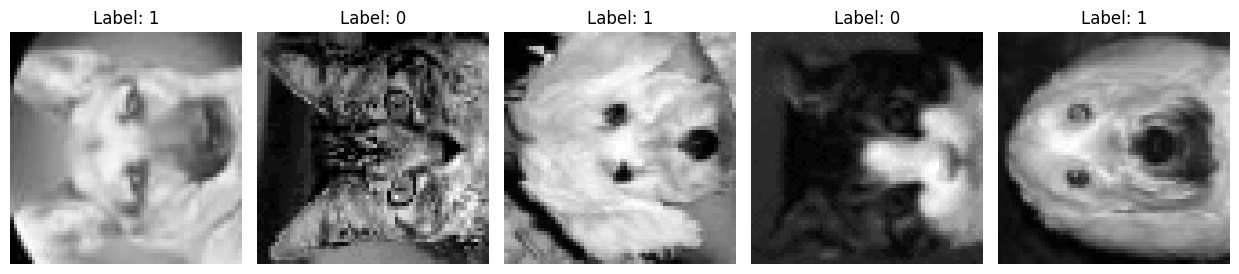

In [7]:
# plot example images
plot_examples(df, n=5)

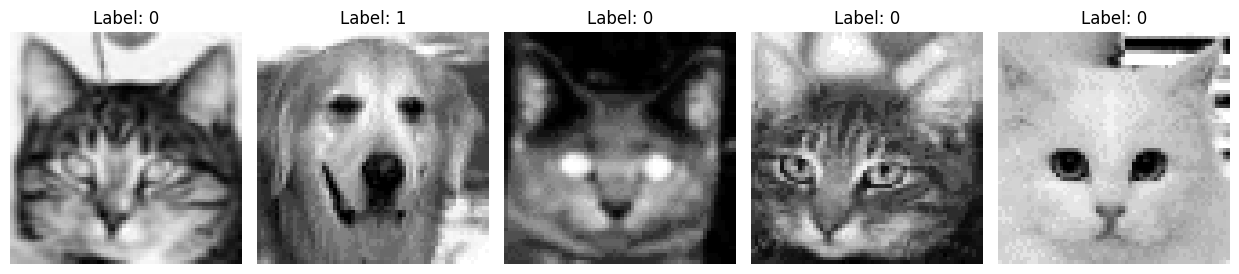

In [8]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

### Fixing the models

#### CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split



In [24]:
class PixelLassoCNN(pl.LightningModule):
    def __init__(self, l1_lambda=1e-2):
        super().__init__()
        self.input_mask = nn.Parameter(torch.ones(1, 1, 64, 64))  # same size as input

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)

        self.l1_lambda = l1_lambda

    def forward(self, x):
        x = x * self.input_mask  # Apply the learnable mask
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss

        self.log("train_loss", total_loss)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", total_loss)
        self.log("test_accuracy", total_accuracy)
        return total_loss, total_accuracy
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", total_loss)
        self.log("val_accuracy", total_accuracy)
        return total_loss, total_accuracy
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
class PixelLassoCNNmnistdigits(PixelLassoCNN):
    def __init__(self, l1_lambda=1e-2):
        super().__init__(l1_lambda=l1_lambda)
        self.input_mask = nn.Parameter(torch.ones(1, 1, 16, 16))  # same size as input
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
        self.l1_lambda = l1_lambda
        
    def forward(self, x):
        x = x * self.input_mask
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss

        self.log("train_loss", total_loss)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", total_loss)
        self.log("test_accuracy", total_accuracy)
        return total_loss, total_accuracy
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", total_loss)
        self.log("val_accuracy", total_accuracy)
        return total_loss, total_accuracy


In [ ]:
# Load the data for training


# Split the data into features and labels

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X = X.reshape(-1, 1, 64, 64)  # Reshape for CNN input

# Split the data into training and validation sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 126
Validation set size: 32
Test set size: 40


### CV for finding optimal Lambda

In [27]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(model.device), y.to(model.device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [25]:
def run_cv_for_lambdas(dataset, lambdas, k_folds=5, batch_size=64, max_epochs=10):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for lmbda in lambdas:
        print(f"\nTesting lambda = {lmbda}")
        val_scores = []
        sparsities = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            print(f"  Fold {fold+1}/{k_folds}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size)

            model = PixelLassoCNNmnistdigits(l1_lambda=lmbda)

            trainer = pl.Trainer(
                max_epochs=max_epochs,
                enable_progress_bar=False,
                logger=False,
                accelerator="auto",
                enable_model_summary=False,
            )
            
            trainer.fit(model, train_loader, val_loader)

            # Eval on validation set
            acc = evaluate_model(model, val_loader)
            mask = model.input_mask.detach().cpu().squeeze()
            mask = mask.numpy()
            sparsity = (mask < 0.01).sum() / mask.size
            print(f"  Validation Accuracy: {acc:.4f}")
            val_scores.append(acc)
            sparsities.append(sparsity)
            
            # cross validation error
            val_loss = trainer.validate(model, val_loader)
            
        results.append({
            "lambda": lmbda,
            "val_acc_mean": np.mean(val_scores),
            "val_acc_std": np.std(val_scores),
            "sparsity_mean": np.mean(sparsities),
            "mask": model.input_mask,
        })

    return results

def plot_cv_results(results):
    lambdas = [r["lambda"] for r in results]
    accs = [r["val_acc_mean"] for r in results]
    sparsities = [r["sparsity_mean"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(lambdas, accs, marker='o')
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(lambdas, sparsities, marker='o', color="red")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Sparsity (fraction of near-zero pixels)")

    plt.tight_layout()
    plt.show()

In [16]:
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Silence Lightning logs
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

lambda_grid = np.logspace(-2, 2, 7)
num_repeats = 5
pixel_selection_counts = []

start_time = time.time()

# Run multiple repeats
for repeat in range(num_repeats):
    print(f"Running cross-validation repeat {repeat+1}/{num_repeats}...")
    
    # Run cross-validation
    results = run_cv_for_lambdas(train_dataset, lambdas=lambda_grid, max_epochs=75)
    
    # Assume run_cv_for_lambdas returns the best trained model
    best_model = max(results, key=lambda x: x["val_acc_mean"])
    best_lambda = best_model["lambda"]
    
    # retrain on the full training set with the best lambda
    print(f"Retraining with best lambda: {best_lambda}")
    model = PixelLassoCNN(l1_lambda=best_lambda)
    trainer = pl.Trainer(
        max_epochs=150,
        enable_progress_bar=False,
        logger=False,
        accelerator="auto",
        enable_model_summary=False,
    )
    trainer.fit(model, train_loader, val_loader)
    
    # Evaluate on the test set
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Sparsity: {model.input_mask.detach().cpu().squeeze().numpy().mean():.4f}")
    
    # Get the mask
    best_mask = model.input_mask.detach().cpu().squeeze().numpy()
    
    # Threshold the mask (select "active" pixels)
    threshold = 0.01
    selected_pixels = (best_mask > threshold).astype(np.float32)
    
    pixel_selection_counts.append(selected_pixels)

end_time = time.time()
print(f"Cross-validation took {end_time - start_time:.2f} seconds")

# Stack and sum selection maps
pixel_selection_counts = np.stack(pixel_selection_counts, axis=0)  # (num_repeats, H, W)
consensus_map = pixel_selection_counts.sum(axis=0)  # (H, W)

# Normalize to [0, 1]
consensus_map_normalized = consensus_map / num_repeats

Running cross-validation repeat 1/5...

Testing lambda = 0.01
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/oskar/Coding/MVE441/project_2/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


  Validation Accuracy: 0.7692


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7692307829856873     │
│         val_loss          │     35.43854522705078     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │    35.711788177490234     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │    35.305076599121094     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     35.32229995727539     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     35.42182159423828     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.3846


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.38461539149284363    │
│         val_loss          │     162.550048828125      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     162.2428741455078     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │    162.06399536132812     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │    162.35964965820312     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     162.2195587158203     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │     750.8032836914062     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     750.7857055664062     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     750.7154541015625     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     750.6101684570312     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │     750.8139038085938     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.5385


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5384615659713745     │
│         val_loss          │       3482.37890625       │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     3482.340087890625     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     3482.187255859375     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     3482.174072265625     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4399999976158142     │
│         val_loss          │     3482.68408203125      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.4231


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.42307692766189575    │
│         val_loss          │      16161.154296875      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │       16160.8046875       │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8799999952316284     │
│         val_loss          │     16160.7158203125      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │      16160.974609375      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │      16160.865234375      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │        75009.46875        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │       75009.5859375       │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │       75009.578125        │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │       75009.4140625       │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │         75009.625         │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.3846


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.38461539149284363    │
│         val_loss          │        348161.5625        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │       348161.40625        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │         348161.25         │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │        348161.375         │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │        348161.375         │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.7250
Sparsity: 0.0033
Running cross-validation repeat 2/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            0.5            │
│         val_loss          │     35.70901107788086     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │    35.518714904785156     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.9200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9200000166893005     │
│         val_loss          │     35.3585319519043      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     35.3074951171875      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │    35.619510650634766     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.3462


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3461538553237915     │
│         val_loss          │    162.62741088867188     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │    162.27944946289062     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │     162.2770233154297     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │    162.27816772460938     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     162.2223663330078     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.7308


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7307692170143127     │
│         val_loss          │     750.8325805664062     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     750.7335205078125     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     750.6377563476562     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     750.8732299804688     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     750.7644653320312     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.3462


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3461538553237915     │
│         val_loss          │     3482.968505859375     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │        3482.515625        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     3482.288330078125     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │     3482.384033203125     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     3482.221923828125     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.7692


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7692307829856873     │
│         val_loss          │     16160.6767578125      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │      16161.146484375      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │      16160.708984375      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │       16160.8984375       │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │     16160.7783203125      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.6154


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6153846383094788     │
│         val_loss          │       75009.5546875       │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │       75009.640625        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │          75009.5          │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │       75009.4609375       │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │       75009.671875        │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.3846


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.38461539149284363    │
│         val_loss          │        348161.5625        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │        348161.375         │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8799999952316284     │
│         val_loss          │         348161.25         │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │        348161.4375        │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │       348161.53125        │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.21544346900318834
Test Accuracy: 0.5250
Sparsity: -0.0000
Running cross-validation repeat 3/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │      35.473876953125      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     35.39325714111328     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     35.44435501098633     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │    35.409996032714844     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     35.46733093261719     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.3462


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3461538553237915     │
│         val_loss          │    162.63172912597656     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │    162.34869384765625     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │    162.16062927246094     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │    162.33091735839844     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     162.2076416015625     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.5385


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5384615659713745     │
│         val_loss          │     750.8792114257812     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │     750.8047485351562     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     750.6646728515625     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     750.7522583007812     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │     750.8900756835938     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │      3482.2119140625      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │      3482.2841796875      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8799999952316284     │
│         val_loss          │     3482.04052734375      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     3482.20166015625      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │     3482.414794921875     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.6154


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6153846383094788     │
│         val_loss          │     16160.8525390625      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     16160.9228515625      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │      16160.587890625      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     16161.0263671875      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │     16160.9541015625      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.3462


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3461538553237915     │
│         val_loss          │       75009.9453125       │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │       75009.8515625       │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.9600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9599999785423279     │
│         val_loss          │       75009.3515625       │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │          75009.5          │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │       75009.5234375       │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.5769


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5769230723381042     │
│         val_loss          │       348161.46875        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │       348161.46875        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │         348161.25         │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │        348161.3125        │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │       348161.53125        │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.7500
Sparsity: 0.0062
Running cross-validation repeat 4/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5769


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5769230723381042     │
│         val_loss          │     35.61191940307617     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │    35.616825103759766     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │    35.381717681884766     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     35.47831344604492     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │    35.569679260253906     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.6538


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6538461446762085     │
│         val_loss          │    162.35336303710938     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │    162.33839416503906     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     162.2543487548828     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     162.2572479248047     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │    162.46981811523438     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │     750.9200439453125     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │     750.8351440429688     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.4000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4000000059604645     │
│         val_loss          │      751.09033203125      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │     750.9252319335938     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │     750.9827880859375     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.7308


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7307692170143127     │
│         val_loss          │      3482.2529296875      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │     3482.352294921875     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     3482.037841796875     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     3482.179931640625     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     3482.249267578125     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.7692


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7692307829856873     │
│         val_loss          │      16160.798828125      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │      16160.857421875      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │      16160.857421875      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │      16160.662109375      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     16160.8212890625      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.6154


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6153846383094788     │
│         val_loss          │       75009.6640625       │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │       75009.5703125       │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.9600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9599999785423279     │
│         val_loss          │        75009.4375         │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │         75009.625         │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │       75009.6796875       │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.5769


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5769230723381042     │
│         val_loss          │        348161.4375        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │       348161.40625        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │        348161.1875        │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │       348161.28125        │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4399999976158142     │
│         val_loss          │        348161.5625        │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 1.0
Test Accuracy: 0.5250
Sparsity: 0.0000
Running cross-validation repeat 5/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.7692


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7692307829856873     │
│         val_loss          │     35.44258117675781     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     35.44807052612305     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.9600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9599999785423279     │
│         val_loss          │     35.23836135864258     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │    35.497108459472656     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5600000023841858     │
│         val_loss          │     35.5163459777832      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.7308


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7307692170143127     │
│         val_loss          │    162.21376037597656     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │    162.34559631347656     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     162.2469024658203     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7600


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7599999904632568     │
│         val_loss          │     162.3065643310547     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │    162.44830322265625     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.7308


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7307692170143127     │
│         val_loss          │     750.773193359375      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47999998927116394    │
│         val_loss          │     750.9735717773438     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │     750.6898193359375     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.8400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8399999737739563     │
│         val_loss          │     750.6906127929688     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6399999856948853     │
│         val_loss          │     750.7586669921875     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.8077


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.807692289352417     │
│         val_loss          │     3482.259521484375     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │     3482.368408203125     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     3482.29345703125      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │     3482.297607421875     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4399999976158142     │
│         val_loss          │     3482.58251953125      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.5000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            0.5            │
│         val_loss          │     16160.9775390625      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │      16160.806640625      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │     16160.9072265625      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6000000238418579     │
│         val_loss          │      16160.912109375      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4400


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4399999976158142     │
│         val_loss          │     16160.9912109375      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.6923


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.692307710647583     │
│         val_loss          │        75009.53125        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │       75009.5703125       │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.8000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.800000011920929     │
│         val_loss          │       75009.3203125       │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │       75009.640625        │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │       75009.640625        │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.7692


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7692307829856873     │
│         val_loss          │       348161.28125        │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │        348161.4375        │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6800


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.6800000071525574     │
│         val_loss          │       348161.40625        │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.7200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7200000286102295     │
│         val_loss          │       348161.28125        │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5199999809265137     │
│         val_loss          │       348161.46875        │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.7000
Sparsity: 0.0036
Cross-validation took 1118.71 seconds


Text(0.5, 1.0, 'Validation Error vs Lambda (CNN)')

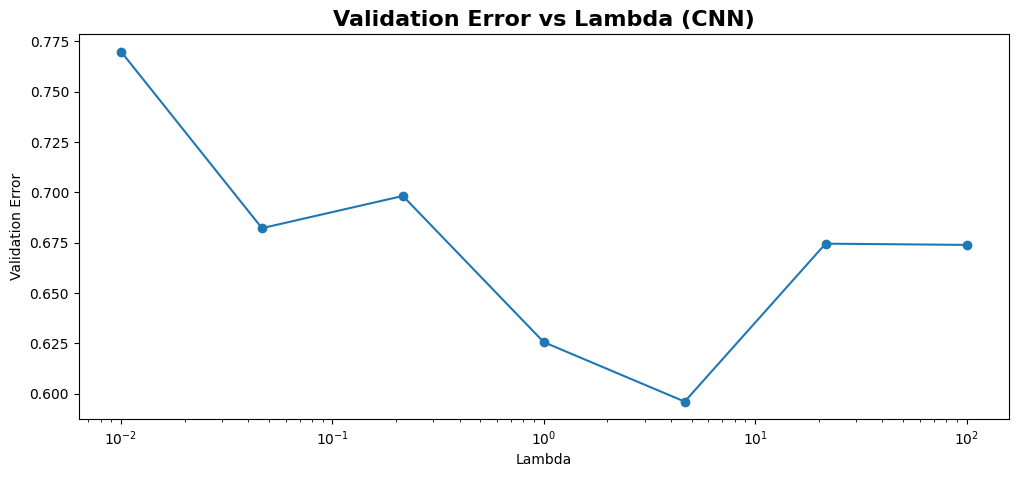

In [ ]:
# plot the val error as a function of lambda
val_errors_catdog = [r["val_acc_mean"] for r in results]
val_errors_catdog = 1 - np.array(val_errors_catdog)  # Convert to error

plt.figure(figsize=(12, 5))
plt.plot(lambda_grid, val_errors_catdog, marker='o')
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Validation Error")
plt.title("Validation Error vs Lambda (CNN)", fontsize=16, fontweight='bold')


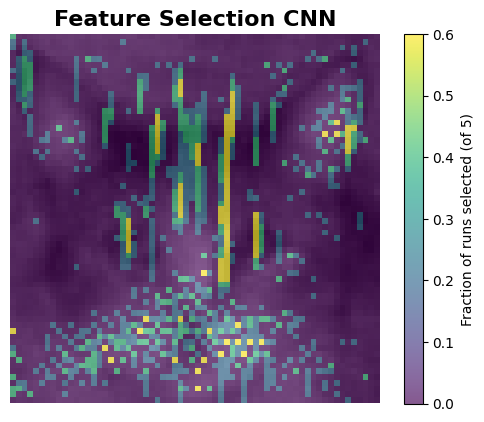

In [23]:
# Plot avg cat
avg_cat = np.mean(X_train[y_train == 0], axis=0)

plt.imshow(avg_cat.reshape(64, 64), cmap="gray", interpolation="nearest")

# layer selection map
plt.imshow(consensus_map_normalized, cmap="viridis", interpolation="nearest", alpha=0.65)
plt.title("Feature Selection CNN", fontsize=16, fontweight="bold")
plt.colorbar(label="Fraction of runs selected (of 5)")
plt.axis("off")
plt.show()

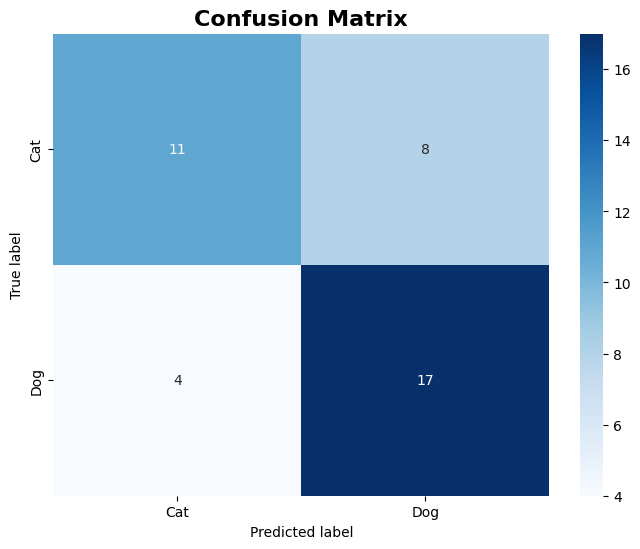

In [25]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.show()
    
# Get predictions
y_pred = []
for x, _ in test_loader:
    x = x.to(model.device)
    preds = model(x).argmax(dim=1)
    y_pred.extend(preds.cpu().numpy())
y_pred = np.array(y_pred)
y_test = y_test_tensor.numpy()
# Plot confusion matrix

plot_confusion_matrix(y_test, y_pred, classes=['Cat', 'Dog'])


# CNN with MNIST digits

In [5]:
# load data

df_mnist = pd.read_csv('Numbers.txt', delimiter=' ')

# first column is the label
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]
df_mnist.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V249,V250,V251,V252,V253,V254,V255,V256,V257,label
1,-1.0,-1.0,-1.0,-1.000,-1.000,-0.972,0.178,1.000,0.689,0.584,...,0.940,1.000,0.400,-0.337,-0.954,-1.0,-1.0,-1.0,-1.0,0
2,-1.0,-1.0,-1.0,-1.000,-1.000,-0.815,0.268,0.640,0.869,-0.363,...,0.990,-0.381,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,9
3,-1.0,-1.0,-1.0,-1.000,-0.987,-0.806,-0.169,0.350,0.986,1.000,...,1.000,1.000,0.832,0.196,-0.714,-1.0,-1.0,-1.0,-1.0,8
4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.851,0.668,-0.858,-1.000,...,-0.017,-0.847,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-9
5,-1.0,-1.0,-1.0,-0.928,0.162,-0.014,-0.210,0.999,1.000,0.623,...,-0.683,0.711,1.000,0.320,-0.928,-1.0,-1.0,-1.0,-1.0,8


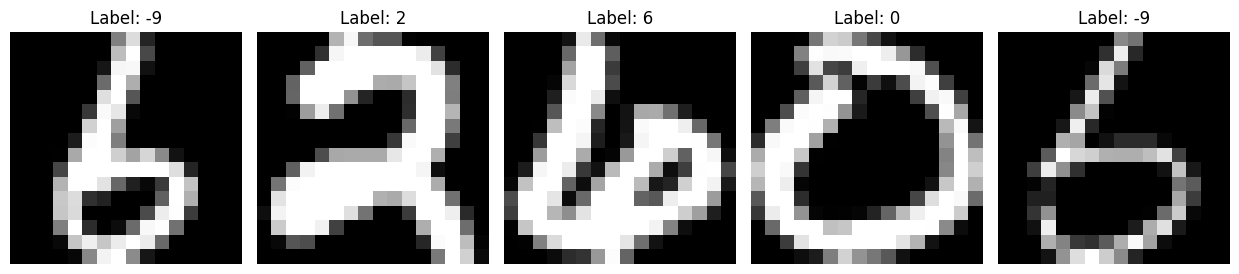

In [10]:
# create a function to plot examples
def plot_examples_mnist(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((16, 16))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# plot example images
plot_examples_mnist(df_mnist, n=5)

In [ ]:
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values

# train test split
X_mnist = X_mnist.reshape(-1, 1, 16, 16)  # Reshape for CNN input
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)
X_mnist_train, X_mnist_val, y_mnist_train, y_mnist_val = train_test_split(X_mnist_train, y_mnist_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_mnist_train_tensor = torch.tensor(X_mnist_train, dtype=torch.float32)
X_mnist_val_tensor = torch.tensor(X_mnist_val, dtype=torch.float32)
y_mnist_train_tensor = torch.tensor(y_mnist_train, dtype=torch.long)
y_mnist_val_tensor = torch.tensor(y_mnist_val, dtype=torch.long)
X_mnist_test_tensor = torch.tensor(X_mnist_test, dtype=torch.float32)
y_mnist_test_tensor = torch.tensor(y_mnist_test, dtype=torch.long)

# Create DataLoader
train_mnist_dataset = TensorDataset(X_mnist_train_tensor, y_mnist_train_tensor)
val_mnist_dataset = TensorDataset(X_mnist_val_tensor, y_mnist_val_tensor)
test_mnist_dataset = TensorDataset(X_mnist_test_tensor, y_mnist_test_tensor)
train_mnist_loader = DataLoader(train_mnist_dataset, batch_size=16, shuffle=True)
val_mnist_loader = DataLoader(val_mnist_dataset, batch_size=16, shuffle=False)
test_mnist_loader = DataLoader(test_mnist_dataset, batch_size=20, shuffle=False)
print(f"Train set size: {len(train_mnist_loader.dataset)}")
print(f"Validation set size: {len(val_mnist_loader.dataset)}")
print(f"Test set size: {len(test_mnist_loader.dataset)}")

Train set size: 1280
Validation set size: 320
Test set size: 400


In [ ]:
import time

# Silence Lightning logs
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# run CV for mnist
lambda_grid_mnist = np.logspace(-2, 2, 7)
num_repeats_mnist = 5
pixel_selection_counts_mnist = []
start_time_mnist = time.time()
# Run multiple repeats
for repeat in range(num_repeats_mnist):
    print(f"Running cross-validation repeat {repeat+1}/{num_repeats_mnist}...")
    
    # Run cross-validation
    results_mnist = run_cv_for_lambdas(train_mnist_dataset, lambdas=lambda_grid_mnist, max_epochs=75)
    
    # Assume run_cv_for_lambdas returns the best trained model
    best_model_mnist = max(results_mnist, key=lambda x: x["val_acc_mean"])
    best_lambda_mnist = best_model_mnist["lambda"]
    
    # retrain on the full training set with the best lambda
    print(f"Retraining with best lambda: {best_lambda_mnist}")
    model_mnist = PixelLassoCNNmnistdigits(l1_lambda=best_lambda_mnist)
    trainer = pl.Trainer(
        max_epochs=150,
        enable_progress_bar=False,
        logger=False,
        accelerator="auto",
        enable_model_summary=False,
    )
    trainer.fit(model_mnist, train_mnist_loader, val_mnist_loader)
    
    # Evaluate on the test set
    test_accuracy = evaluate_model(model_mnist, test_mnist_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Sparsity: {model_mnist.input_mask.detach().cpu().squeeze().numpy().mean():.4f}")
    
    # Get the mask
    best_mask = model_mnist.input_mask.detach().cpu().squeeze().numpy()
    
    # Threshold the mask (select "active" pixels)
    threshold = 0.01
    selected_pixels = (best_mask > threshold).astype(np.float32)
    
    pixel_selection_counts_mnist.append(selected_pixels)
    
end_time_mnist = time.time()
print(f"Cross-validation took {end_time_mnist - start_time_mnist:.2f} seconds")



Running cross-validation repeat 1/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5430


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.54296875         │
│         val_loss          │    0.9031749963760376     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5625


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.5625           │
│         val_loss          │    0.9506121277809143     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.5898


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.58984375         │
│         val_loss          │     0.853368878364563     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5820


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.58203125         │
│         val_loss          │    0.9393038153648376     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6484


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.6484375         │
│         val_loss          │     0.789070725440979     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.4336


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.43359375         │
│         val_loss          │    1.0117197036743164     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4492


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.44921875         │
│         val_loss          │    1.0488526821136475     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.4609


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.4609375         │
│         val_loss          │    1.0521681308746338     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.4922


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.4921875         │
│         val_loss          │    1.1407506465911865     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4844


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.484375          │
│         val_loss          │    0.9901821613311768     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.3281


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.328125          │
│         val_loss          │    1.4036226272583008     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.3047


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3046875         │
│         val_loss          │     1.394426941871643     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.3438


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.34375          │
│         val_loss          │    1.4153165817260742     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │    1.5324811935424805     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.3555


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.35546875         │
│         val_loss          │    1.3070653676986694     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │     1.520248293876648     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.5213061571121216     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.5634026527404785     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     1.622812271118164     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.5139890909194946     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │     1.639546275138855     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.6639610528945923     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │    1.6674423217773438     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    1.7438504695892334     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.6213160753250122     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    2.1749885082244873     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │    2.2017650604248047     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │     2.223475933074951     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    2.2900378704071045     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │     2.165289878845215     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │     5.46886682510376      │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │     5.419503211975098     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │     5.129374027252197     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    5.4603071212768555     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │     5.325971603393555     │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.7275
Sparsity: 0.0073
Running cross-validation repeat 2/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.6133


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.61328125         │
│         val_loss          │    0.8243651390075684     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5938


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.59375          │
│         val_loss          │    0.8996496200561523     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.5547


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.5546875         │
│         val_loss          │    0.8939158916473389     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5312


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.53125          │
│         val_loss          │    0.9536435604095459     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.64453125         │
│         val_loss          │    0.8037039041519165     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.4727


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.47265625         │
│         val_loss          │    1.0315967798233032     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4219


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.421875          │
│         val_loss          │    1.0802745819091797     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.4805


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.48046875         │
│         val_loss          │     1.054877519607544     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.4883


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.48828125         │
│         val_loss          │    1.1363365650177002     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5156


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.515625          │
│         val_loss          │    1.0096595287322998     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.3281


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.328125          │
│         val_loss          │    1.4005101919174194     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.3047


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3046875         │
│         val_loss          │    1.4064775705337524     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │    1.3974391222000122     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │    1.5161778926849365     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.3555


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.35546875         │
│         val_loss          │    1.2783839702606201     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    1.5316343307495117     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.5311938524246216     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │    1.5546950101852417     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    1.6254639625549316     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │     1.518134593963623     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    1.6460074186325073     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.6454014778137207     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.6721196174621582     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.7425051927566528     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │    1.6232967376708984     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │     2.140195846557617     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     2.186903238296509     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    2.2323920726776123     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    2.2841227054595947     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │     2.156967878341675     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │     5.317695617675781     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │     5.42389440536499      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │     5.150448799133301     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     5.53568172454834      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │     5.324814796447754     │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.7025
Sparsity: 0.0093
Running cross-validation repeat 3/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5938


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.59375          │
│         val_loss          │    0.8409478664398193     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5742


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.57421875         │
│         val_loss          │    0.9279754161834717     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.5547


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.5546875         │
│         val_loss          │    0.8987529277801514     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5742


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.57421875         │
│         val_loss          │    0.9218186140060425     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6094


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.609375          │
│         val_loss          │    0.7986717820167542     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.4414


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.44140625         │
│         val_loss          │     1.036607265472412     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4141


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.4140625         │
│         val_loss          │    1.0750012397766113     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.4648


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.46484375         │
│         val_loss          │    1.0607346296310425     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.4688


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.46875          │
│         val_loss          │    1.1279852390289307     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.5000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            0.5            │
│         val_loss          │    0.9903600215911865     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.3633


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.36328125         │
│         val_loss          │    1.3761816024780273     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.3203


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3203125         │
│         val_loss          │    1.3568662405014038     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.3320


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.33203125         │
│         val_loss          │    1.4297473430633545     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │     1.453637719154358     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.3945


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.39453125         │
│         val_loss          │     1.343276023864746     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │     1.504615306854248     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.5498954057693481     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.5585529804229736     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    1.6244237422943115     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.5113565921783447     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    1.6118764877319336     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │    1.6159982681274414     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │     1.684557318687439     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    1.7720108032226562     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.6279319524765015     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    2.1509318351745605     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │    2.1582744121551514     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    2.2164483070373535     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    2.3002772331237793     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │    2.1726551055908203     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    5.3820414543151855     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     4.906198024749756     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │     5.277095794677734     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     5.225862503051758     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │     5.21245002746582      │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.6875
Sparsity: 0.0088
Running cross-validation repeat 4/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5820


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.58203125         │
│         val_loss          │    0.8298656344413757     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5938


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.59375          │
│         val_loss          │    0.8882145881652832     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6055


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.60546875         │
│         val_loss          │    0.8367951512336731     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.5586


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.55859375         │
│         val_loss          │    0.9382011890411377     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.62109375         │
│         val_loss          │    0.7832276821136475     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.4570


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.45703125         │
│         val_loss          │    1.0316535234451294     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4336


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.43359375         │
│         val_loss          │    1.0719654560089111     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.4414


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.44140625         │
│         val_loss          │    1.0823780298233032     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.4961


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.49609375         │
│         val_loss          │    1.1212831735610962     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4648


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.46484375         │
│         val_loss          │    1.0102365016937256     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.3281


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.328125          │
│         val_loss          │    1.3868581056594849     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.3047


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3046875         │
│         val_loss          │    1.3545528650283813     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.3320


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.33203125         │
│         val_loss          │    1.4622762203216553     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │    1.5209109783172607     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.3555


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.35546875         │
│         val_loss          │    1.3906784057617188     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    1.5072519779205322     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     1.522939682006836     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.5540412664413452     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     1.643595576286316     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.5636557340621948     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    1.6098096370697021     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.6453648805618286     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.6689090728759766     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    1.7240512371063232     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │     1.680046796798706     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    2.1841773986816406     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     2.19699764251709      │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    2.2126753330230713     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    2.2757153511047363     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │     2.14359974861145      │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │     5.369332313537598     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     5.096553325653076     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │     5.355566024780273     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     5.70618200302124      │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │    5.0082597732543945     │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.6850
Sparsity: 0.0121
Running cross-validation repeat 5/5...

Testing lambda = 0.01
  Fold 1/5
  Validation Accuracy: 0.5391


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.5390625         │
│         val_loss          │    0.8678044080734253     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.5977


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.59765625         │
│         val_loss          │    0.9204857349395752     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.6133


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.61328125         │
│         val_loss          │    0.9042066931724548     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.6133


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.61328125         │
│         val_loss          │    0.8764408230781555     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.6406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.640625          │
│         val_loss          │    0.7896857857704163     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.046415888336127774
  Fold 1/5
  Validation Accuracy: 0.4258


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.42578125         │
│         val_loss          │     1.044755220413208     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.4570


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.45703125         │
│         val_loss          │    1.0774763822555542     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.5078


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.5078125         │
│         val_loss          │     1.059877634048462     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.4570


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.45703125         │
│         val_loss          │    1.1366091966629028     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.4883


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.48828125         │
│         val_loss          │    0.9944218993186951     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 0.21544346900318834
  Fold 1/5
  Validation Accuracy: 0.3281


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.328125          │
│         val_loss          │    1.3802318572998047     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.3047


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3046875         │
│         val_loss          │    1.4001214504241943     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.3359


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.3359375         │
│         val_loss          │    1.3788344860076904     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.3789


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.37890625         │
│         val_loss          │    1.4642512798309326     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.3555


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.35546875         │
│         val_loss          │     1.370623230934143     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 1.0
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │    1.5063303709030151     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.5499194860458374     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.5559992790222168     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │    1.6240652799606323     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    1.5048911571502686     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 4.6415888336127775
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    1.6395342350006104     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │    1.6290680170059204     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │    1.6615759134292603     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    1.7685116529464722     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │    1.6218504905700684     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 21.54434690031882
  Fold 1/5
  Validation Accuracy: 0.1211


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.12109375         │
│         val_loss          │    2.1792733669281006     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1641


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.1640625         │
│         val_loss          │     2.143904685974121     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1758


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.17578125         │
│         val_loss          │     2.20961594581604      │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.14453125         │
│         val_loss          │    2.2669098377227783     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1680


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16796875         │
│         val_loss          │    2.1745381355285645     │
└───────────────────────────┴───────────────────────────┘


Testing lambda = 100.0
  Fold 1/5
  Validation Accuracy: 0.2070


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.20703125         │
│         val_loss          │     5.413998603820801     │
└───────────────────────────┴───────────────────────────┘

  Fold 2/5
  Validation Accuracy: 0.1406


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │         0.140625          │
│         val_loss          │     4.933269500732422     │
└───────────────────────────┴───────────────────────────┘

  Fold 3/5
  Validation Accuracy: 0.1602


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.16015625         │
│         val_loss          │     5.391655921936035     │
└───────────────────────────┴───────────────────────────┘

  Fold 4/5
  Validation Accuracy: 0.1914


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │        0.19140625         │
│         val_loss          │     5.165156364440918     │
└───────────────────────────┴───────────────────────────┘

  Fold 5/5
  Validation Accuracy: 0.1875


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │          0.1875           │
│         val_loss          │     5.180158615112305     │
└───────────────────────────┴───────────────────────────┘

Retraining with best lambda: 0.01
Test Accuracy: 0.6950
Sparsity: 0.0170
Cross-validation took 3403.47 seconds


NameError: name 'num_repeats' is not defined

In [31]:
# Stack and sum selection maps
pixel_selection_counts_mnist = np.stack(pixel_selection_counts_mnist, axis=0)  # (num_repeats, H, W)
consensus_map_mnist = pixel_selection_counts_mnist.sum(axis=0)  # (H, W)

# Normalize to [0, 1]
consensus_map_mnist_normalized = consensus_map_mnist / num_repeats_mnist

Text(0.5, 1.0, 'Validation Error vs Lambda (MNIST)')

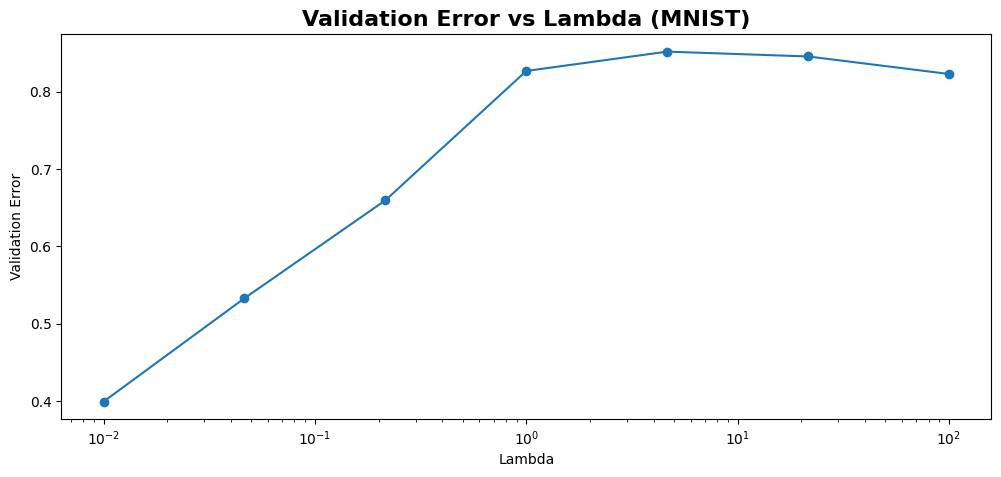

In [32]:
# plot the val error as a function of lambda
val_errors_mnist = [r["val_acc_mean"] for r in results_mnist]
val_errors_mnist = 1 - np.array(val_errors_mnist)  # Convert to error

plt.figure(figsize=(12, 5))
plt.plot(lambda_grid_mnist, val_errors_mnist, marker='o')
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Validation Error")
plt.title("Validation Error vs Lambda (MNIST)", fontsize=16, fontweight='bold')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


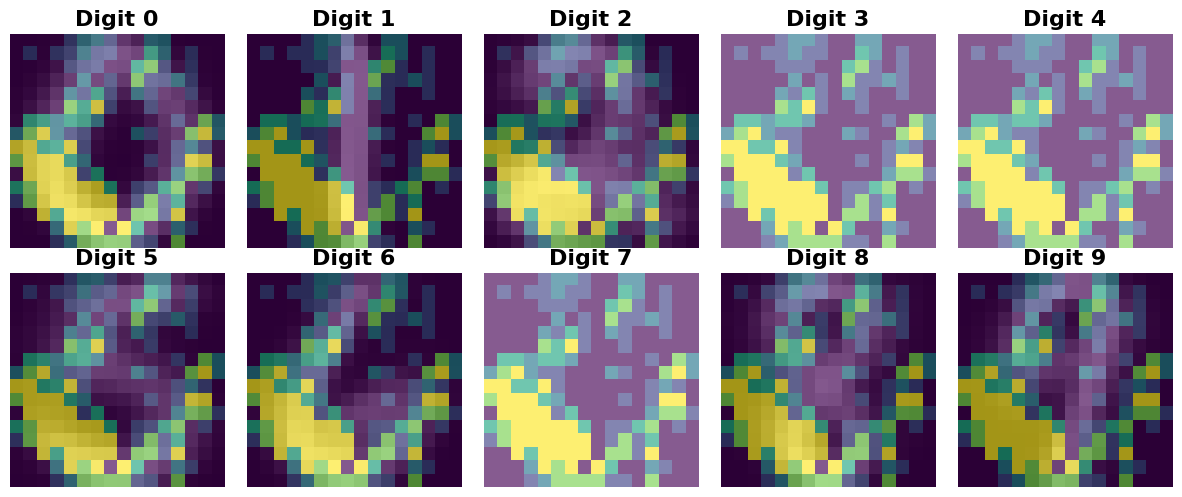

In [ ]:
# get the average digit

avg_digit0 = np.mean(X_mnist_train[y_mnist_train == 0], axis=0)
avg_digit1 = np.mean(X_mnist_train[y_mnist_train == 1], axis=0)
avg_digit2 = np.mean(X_mnist_train[y_mnist_train == 2], axis=0)
avg_digit3 = np.mean(X_mnist_train[y_mnist_train == 3], axis=0)
avg_digit4 = np.mean(X_mnist_train[y_mnist_train == 4], axis=0)
avg_digit5 = np.mean(X_mnist_train[y_mnist_train == 5], axis=0)
avg_digit6 = np.mean(X_mnist_train[y_mnist_train == 6], axis=0)
avg_digit7 = np.mean(X_mnist_train[y_mnist_train == 7], axis=0)
avg_digit8 = np.mean(X_mnist_train[y_mnist_train == 8], axis=0)
avg_digit9 = np.mean(X_mnist_train[y_mnist_train == 9], axis=0)

# plot the consensus map over the average digits
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(eval(f"avg_digit{i}").reshape(16, 16), cmap="gray", interpolation="nearest")
    plt.imshow(consensus_map_mnist_normalized, cmap="viridis", interpolation="nearest", alpha=0.65)
    plt.title(f"Digit {i}", fontsize=16, fontweight="bold")
    plt.axis("off")
plt.tight_layout()
plt.show()

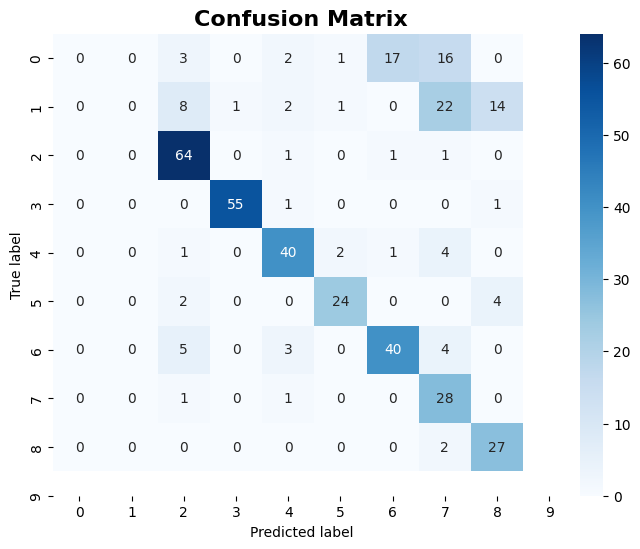

In [34]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.show()
    
# Get predictions
y_pred_mnist = []
for x, _ in test_mnist_loader:
    x = x.to(model_mnist.device)
    preds = model_mnist(x).argmax(dim=1)
    y_pred_mnist.extend(preds.cpu().numpy())
y_pred_mnist = np.array(y_pred_mnist)
y_mnist_test = y_mnist_test_tensor.numpy()
# Plot confusion matrix
plot_confusion_matrix(y_mnist_test, y_pred_mnist, classes=[str(i) for i in range(10)])

### SVM using Lasso and Forward selection

In [75]:
# Cell 1
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import train_test_split


nCV = 5
holdout = 0.2

In [82]:
# Cell 2
df = pd.read_csv('catdogdata.txt', delimiter=' ')
df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries

rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [83]:
df_mnist = pd.read_csv('Numbers.txt', delimiter=' ')

# first column is the label
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]
df_mnist.head()
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values


In [85]:
# Cell 3

# Pipeline for Random Forest using F-test for feature selection
pipelineRFFilter = Pipeline([
    ('scaler', StandardScaler()),  # optional; RF doesn't require scaling but good for consistency
    ('feature_selection', SelectKBest(score_func=f_classif)), 
    ('classifier', RandomForestClassifier(n_estimators=100))
])

rf_filter_param_grid_mnist = {
    'feature_selection__k': [k for k in range(1, 256, 10)]
} 

rf_filter_param_grid_catdog = {
    'feature_selection__k': [k for k in range(100, 4100, 200)]
} 

pipelineRFEmbedded = Pipeline([
    ('scaler', StandardScaler()),  # optional; RF doesn't require scaling but good for consistency
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

rf_embedded_param_grid_mnist = {
    'feature_selection__estimator__n_estimators': [k for k in range(1, 256, 10)],
}
 
rf_embedded_param_grid_catdog = {
    'feature_selection__estimator__n_estimators': [k for k in range(100, 4100, 200)],
}

# Pipline for RF using PCA and random projections

pipeline_rf_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', PCA()),
    ('classifier', RandomForestClassifier())
])

pipeline_rf_rp = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', GaussianRandomProjection()),
    ('classifier', RandomForestClassifier())
])

rf_component_param_grid_mnist = {
    'feature_selection__n_components': [k for k in range(1, int(X_mnist.shape[0]*(1-holdout)//nCV * (nCV - 1)), 10)],
}
 
rf_component_param_grid_catdog = {
    'feature_selection__n_components': [k for k in range(1, int(X.shape[0]*(1-holdout)//nCV * (nCV - 1)), 5)],
}


In [87]:
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

def fit_and_evaluate_pipeline_manualgrid(pipeline, Xdata, ydata, param_grid, cv=5, holdout_size=0.2,
                                                      scoring='accuracy',  
                                                      classifier_step_name='classifier', 
                                                      feature_selection_step_name='feature_selection'):
    best_score = -np.inf
    best_result = None
    best_param_value = None
    all_cv_scores = []

    # Store per-param stats
    feature_selection_masks = {}
    model_weights_per_param = {}

    param_name, param_values = list(param_grid.items())[0]

    # Split data into training + holdout sets
    X_train, X_holdout, y_train, y_holdout = train_test_split(Xdata, ydata, test_size=holdout_size, random_state=42)

    for val in param_values:
        pipeline.set_params(**{param_name: val})

        try:
            # Cross-validation on the training data
            cv_result = cross_validate(
                pipeline, X_train, y_train, cv=cv, return_estimator=True, scoring=scoring
            )
        except ValueError as e:
            print(f"Skipping {param_name}={val} due to error: {e}")
            continue

        mean_score = np.mean(cv_result['test_score'])
        all_cv_scores.append((val, mean_score))

        model_weights = []
        has_mask = False
        masks = []

        for estimator in cv_result['estimator']:
            fs_step = estimator.named_steps[feature_selection_step_name]
            clf = estimator.named_steps[classifier_step_name]

            # Try feature selection mask
            if hasattr(fs_step, "get_support"):
                mask = fs_step.get_support()
                masks.append(mask)
                has_mask = True
            else:
                mask = None  # No mask, no selection stats

            # Try model weights or importance
            if hasattr(clf, "coef_"):
                coef = clf.coef_
                avg_coef = np.mean(coef, axis=0) if coef.ndim == 2 else coef.flatten()
            elif hasattr(clf, "feature_importances_"):
                avg_coef = clf.feature_importances_
            else:
                avg_coef = np.zeros(X_train.shape[1])  # fallback

            if mask is not None:
                weights = np.zeros(X_train.shape[1])
                weights[mask] = avg_coef
            else:
                # PCA or RP: transformed feature space → just store raw importances
                weights = avg_coef

            model_weights.append(weights)

        model_weights_per_param[val] = np.array(model_weights)
        if has_mask:
            feature_selection_masks[val] = masks

        if mean_score > best_score:
            best_score = mean_score
            best_result = cv_result
            best_param_value = val

    print(f"\nBest {param_name}: {best_param_value}")
    print(f"Best CV {scoring}: {best_score:.4f}")

    # === Evaluate on holdout (validation) dataset ===
    pipeline.set_params(**{param_name: best_param_value})
    pipeline.fit(X_train, y_train)
    holdout_score = pipeline.score(X_holdout, y_holdout)

    print(f"Holdout {scoring}: {holdout_score:.4f}")

    # === Final stats (only if masks available) ===
    if best_param_value in feature_selection_masks:
        masks = np.array(feature_selection_masks[best_param_value])
        selection_counts = np.sum(masks, axis=0)
    else:
        selection_counts = None  # Not applicable

    mean_importance = np.mean(model_weights_per_param[best_param_value], axis=0)
    cv_errors = [(val, 1 - acc) for val, acc in all_cv_scores]

    return {
        'best_param': best_param_value,
        'cv_accuracy_per_param': all_cv_scores,
        'cv_error_per_param': cv_errors,
        'holdout_score': holdout_score,
        'feature_selection_counts': selection_counts/cv if selection_counts is not None else None,
        'feature_importance': mean_importance,
        'all_selection_masks': feature_selection_masks if feature_selection_masks else None,
        'all_weights': model_weights_per_param
    }


In [96]:
# Fit and evaluate RF with F-test feature selection on mnist digits

results_RF_Filter_mnist = fit_and_evaluate_pipeline_manualgrid(pipelineRFFilter, X_mnist, y_mnist, rf_filter_param_grid_mnist, nCV, holdout)



Best feature_selection__k: 251
Best CV accuracy: 0.9369
Holdout accuracy: 0.9175


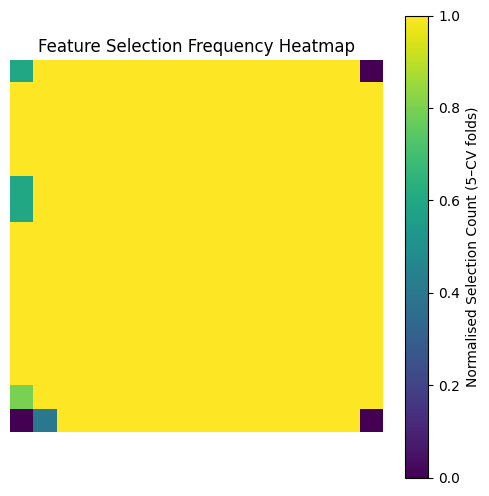

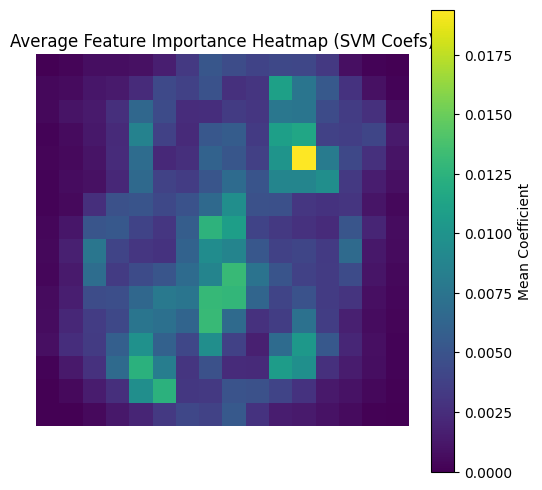

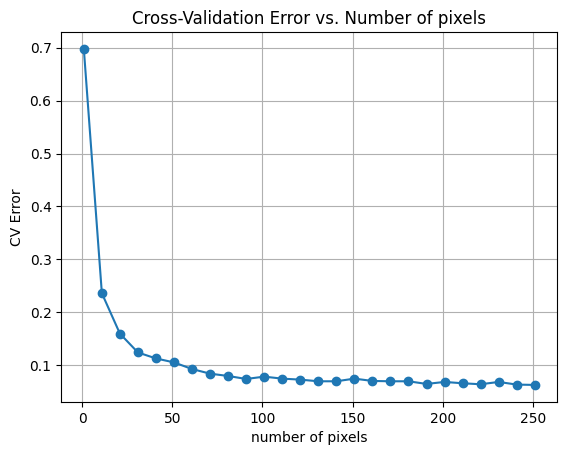

In [97]:
n, m = (16,16)

selection_counts = results_RF_Filter_mnist['feature_selection_counts']
selection_map_2d = np.reshape(selection_counts, (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(selection_map_2d, cmap='viridis', interpolation='nearest')
plt.title("Feature Selection Frequency Heatmap")
plt.colorbar(label="Normalised Selection Count (5–CV folds)")
plt.axis('off')
plt.show()

importance_2d = np.reshape(np.abs(results_RF_Filter_mnist['feature_importance']), (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(importance_2d, cmap='viridis', interpolation='nearest')
plt.title("Average Feature Importance Heatmap (SVM Coefs)")
plt.colorbar(label="Mean Coefficient")
plt.axis('off')
plt.show()

params, errors = zip(*results_RF_Filter_mnist['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of pixels")
plt.xlabel("number of pixels")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


In [98]:
# Fit and evaluate RF with embedded feature selection on mnist digits

results_RF_embedded_mnist = fit_and_evaluate_pipeline_manualgrid(pipelineRFEmbedded, X_mnist, y_mnist, rf_embedded_param_grid_mnist, nCV)


Best feature_selection__estimator__n_estimators: 201
Best CV accuracy: 0.9275
Holdout accuracy: 0.9100


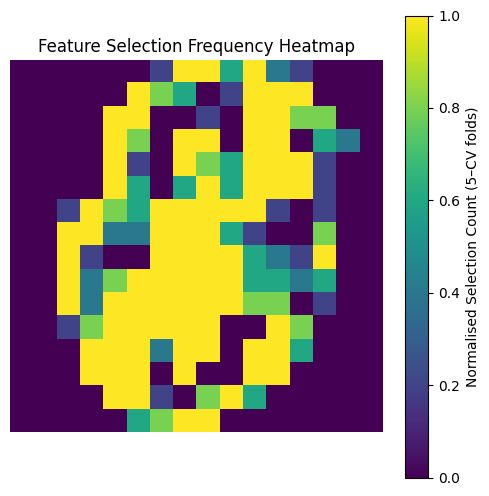

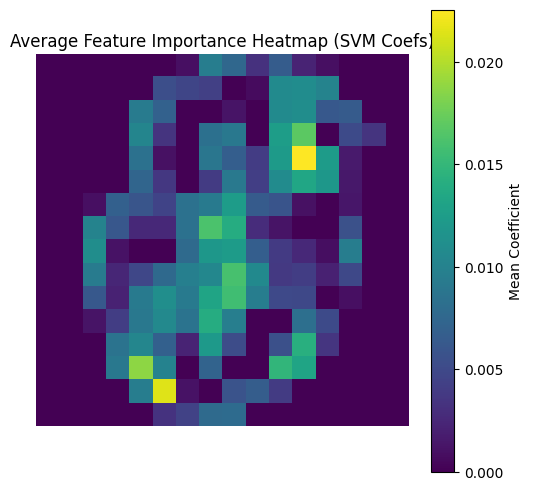

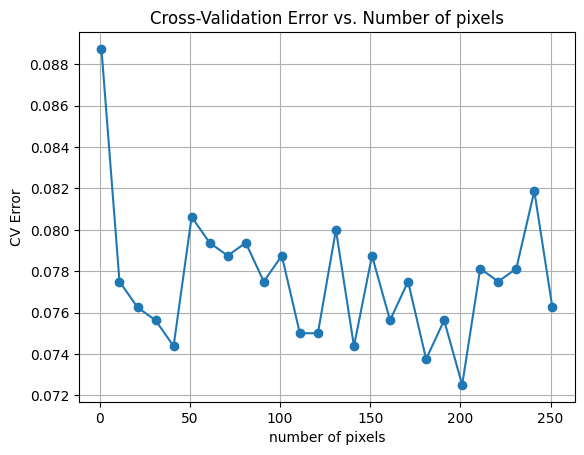

In [99]:

n, m = (16,16)

selection_counts = results_RF_embedded_mnist['feature_selection_counts']
selection_map_2d = np.reshape(selection_counts, (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(selection_map_2d, cmap='viridis', interpolation='nearest')
plt.title("Feature Selection Frequency Heatmap")
plt.colorbar(label="Normalised Selection Count (5–CV folds)")
plt.axis('off')
plt.show()

importance_2d = np.reshape(np.abs(results_RF_embedded_mnist['feature_importance']), (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(importance_2d, cmap='viridis', interpolation='nearest')
plt.title("Average Feature Importance Heatmap (SVM Coefs)")
plt.colorbar(label="Mean Coefficient")
plt.axis('off')
plt.show()

params, errors = zip(*results_RF_embedded_mnist['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of pixels")
plt.xlabel("number of pixels")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


In [100]:
# Fit and evaluate RF using F-test selection method with the catdog dataset

results_RF_Filter_catdog = fit_and_evaluate_pipeline_manualgrid(pipelineRFFilter, X, y, rf_filter_param_grid_catdog, nCV)


Best feature_selection__k: 3700
Best CV accuracy: 0.8292
Holdout accuracy: 0.7250


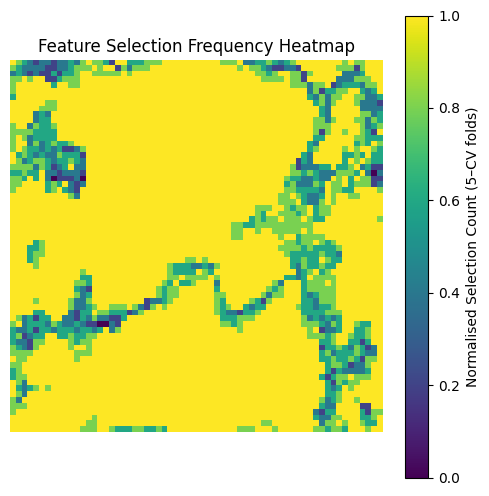

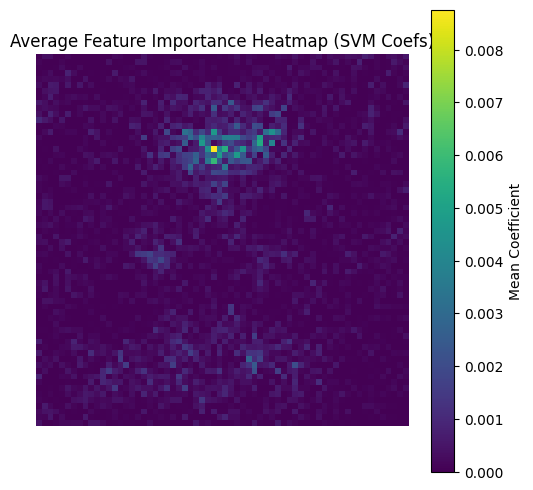

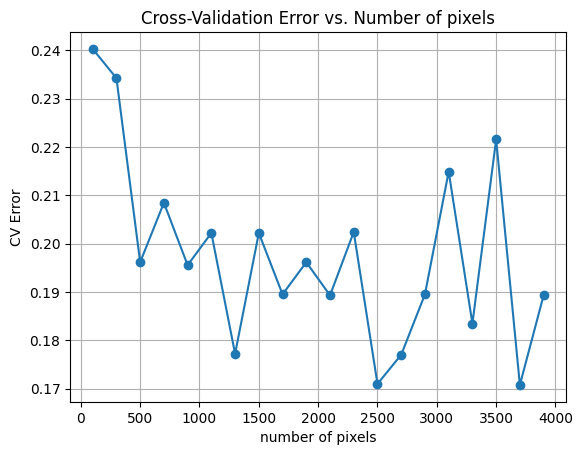

In [101]:
n, m = (64,64)

selection_counts = results_RF_Filter_catdog['feature_selection_counts']
selection_map_2d = np.reshape(selection_counts, (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(selection_map_2d, cmap='viridis', interpolation='nearest')
plt.title("Feature Selection Frequency Heatmap")
plt.colorbar(label="Normalised Selection Count (5–CV folds)")
plt.axis('off')
plt.show()

importance_2d = np.reshape(results_RF_Filter_catdog['feature_importance'], (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(importance_2d, cmap='viridis', interpolation='nearest')
plt.title("Average Feature Importance Heatmap (SVM Coefs)")
plt.colorbar(label="Mean Coefficient")
plt.axis('off')
plt.show()

params, errors = zip(*results_RF_Filter_catdog['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of pixels")
plt.xlabel("number of pixels")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


In [102]:
# Fit and evaluate RF using embedded selection method with the catdog dataset

results_RF_embedded_catdog = fit_and_evaluate_pipeline_manualgrid(pipelineRFEmbedded, X, y, rf_embedded_param_grid_catdog, nCV)


Best feature_selection__estimator__n_estimators: 1700
Best CV accuracy: 0.8415
Holdout accuracy: 0.8000


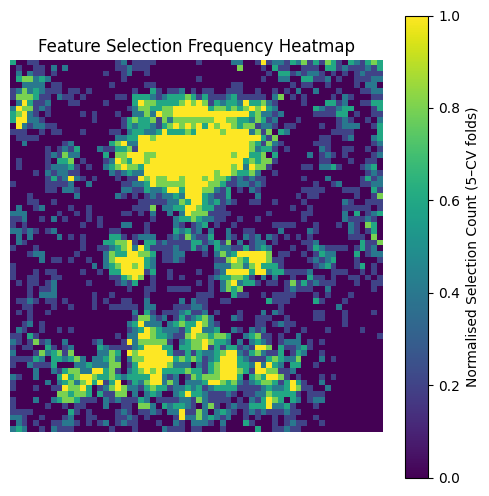

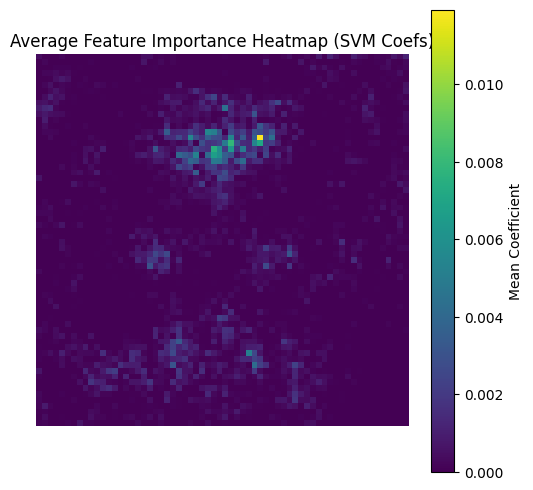

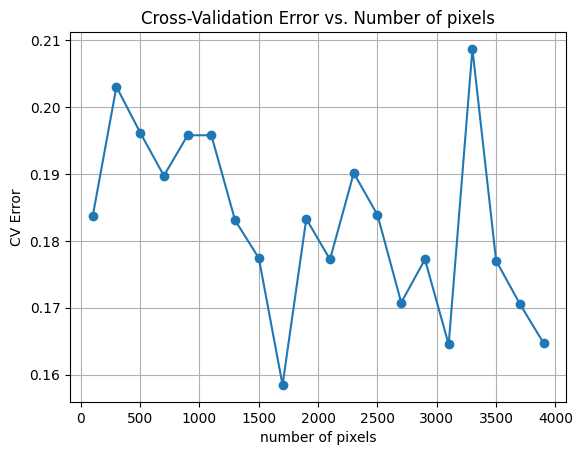

In [103]:
n, m = (64,64)

selection_counts = results_RF_embedded_catdog['feature_selection_counts']
selection_map_2d = np.reshape(selection_counts, (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(selection_map_2d, cmap='viridis', interpolation='nearest')
plt.title("Feature Selection Frequency Heatmap")
plt.colorbar(label="Normalised Selection Count (5–CV folds)")
plt.axis('off')
plt.show()

importance_2d = np.reshape(np.abs(results_RF_embedded_catdog['feature_importance']), (n, m))

plt.figure(figsize=(6, 6))
plt.imshow(importance_2d, cmap='viridis', interpolation='nearest')
plt.title("Average Feature Importance Heatmap (SVM Coefs)")
plt.colorbar(label="Mean Coefficient")
plt.axis('off')
plt.show()

params, errors = zip(*results_RF_embedded_catdog['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of pixels")
plt.xlabel("number of pixels")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


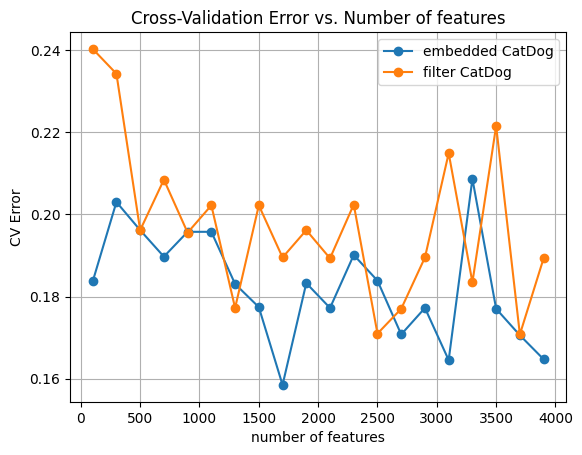

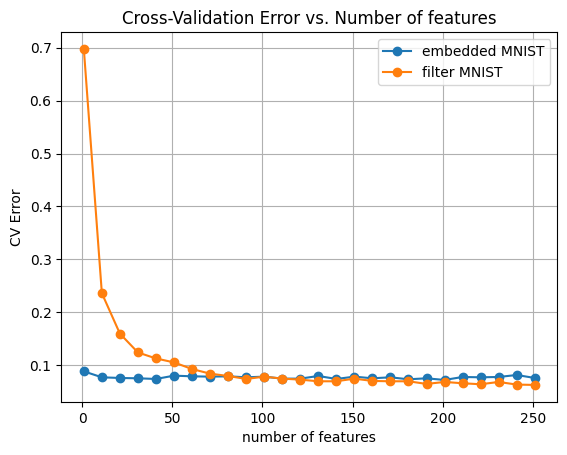

In [114]:
params1, errors1 = zip(*results_RF_embedded_catdog['cv_error_per_param'])
params2, errors2 = zip(*results_RF_Filter_catdog['cv_error_per_param'])
params3, errors3 = zip(*results_RF_embedded_mnist['cv_error_per_param'])
params4, errors4 = zip(*results_RF_Filter_mnist['cv_error_per_param'])
plt.plot(params1, errors1, marker='o', label='embedded CatDog')
plt.plot(params2, errors2, marker='o', label='filter CatDog') 
plt.title("Cross-Validation Error vs. Number of features")
plt.xlabel("number of features")
plt.ylabel("CV Error")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(params3, errors3, marker='o', label='embedded MNIST')
plt.plot(params4, errors4, marker='o', label='filter MNIST') 
plt.title("Cross-Validation Error vs. Number of features")
plt.xlabel("number of features")
plt.ylabel("CV Error")
plt.legend()
plt.grid(True)
plt.show()

### Theme 2
# Random forest

In [104]:
# Fit and evaluate RF using embedded selection method with the catdog dataset

results_RF_PCA_catdog = fit_and_evaluate_pipeline_manualgrid(pipeline_rf_pca, X, y, rf_component_param_grid_catdog, nCV)


Best feature_selection__n_components: 26
Best CV accuracy: 0.8474
Holdout accuracy: 0.8500


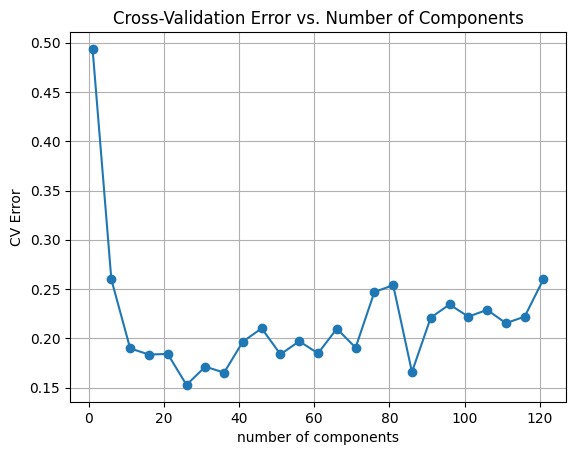

In [105]:
params, errors = zip(*results_RF_PCA_catdog['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of Components")
plt.xlabel("number of components")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


In [106]:
# Fit and evaluate RF using Random projections selection method with the catdog dataset

results_RF_RP_catdog = fit_and_evaluate_pipeline_manualgrid(pipeline_rf_rp, X, y, rf_component_param_grid_catdog, nCV)


Best feature_selection__n_components: 86
Best CV accuracy: 0.8165
Holdout accuracy: 0.7750


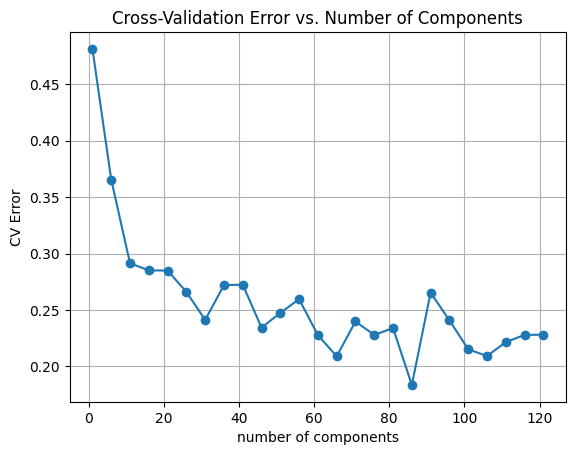

In [107]:
params, errors = zip(*results_RF_RP_catdog['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of Components")
plt.xlabel("number of components")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()


In [108]:
# Fit and evaluate RF using PCA selection method with the mnist dataset

results_RF_PCA_mnist = fit_and_evaluate_pipeline_manualgrid(pipeline_rf_pca, X_mnist, y_mnist, rf_component_param_grid_mnist, nCV)

Skipping feature_selection__n_components=261 due to error: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\maxfr\AppData\Local\Programs\Python

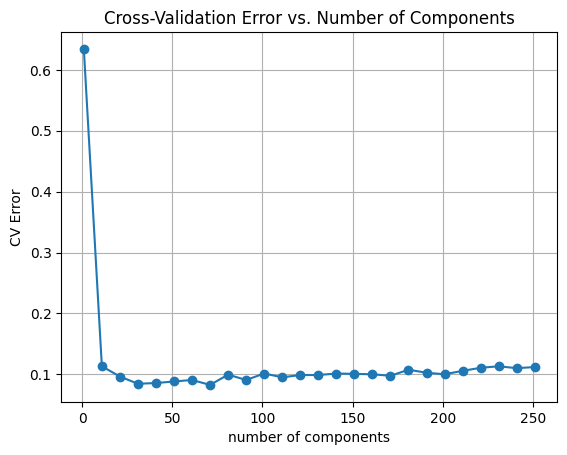

In [109]:
params, errors = zip(*results_RF_PCA_mnist['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of Components")
plt.xlabel("number of components")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()

In [110]:
# Fit and evaluate RF using PCA selection method with the mnist dataset

results_RF_RP_mnist = fit_and_evaluate_pipeline_manualgrid(pipeline_rf_rp, X_mnist, y_mnist, rf_component_param_grid_mnist, nCV)

c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (256 < 261).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (256 < 261).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (256 < 261).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\skl


Best feature_selection__n_components: 831
Best CV accuracy: 0.9213


c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (256 < 831).The dimensionality of the problem will not be reduced.
  warnings.warn(


Holdout accuracy: 0.8875


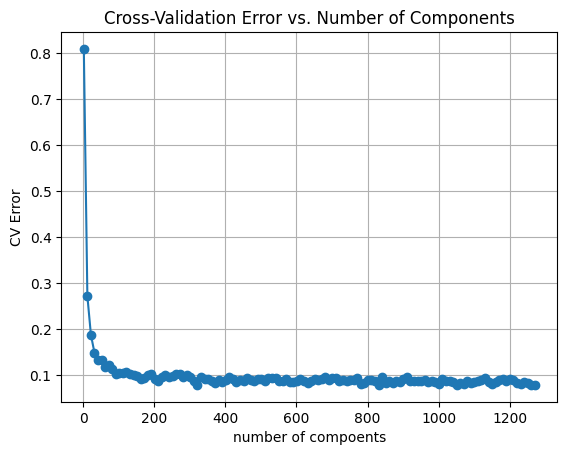

In [111]:
params, errors = zip(*results_RF_RP_mnist['cv_error_per_param'])
plt.plot(params, errors, marker='o')
plt.title("Cross-Validation Error vs. Number of Components")
plt.xlabel("number of compoents")
plt.ylabel("CV Error")
plt.grid(True)
plt.show()

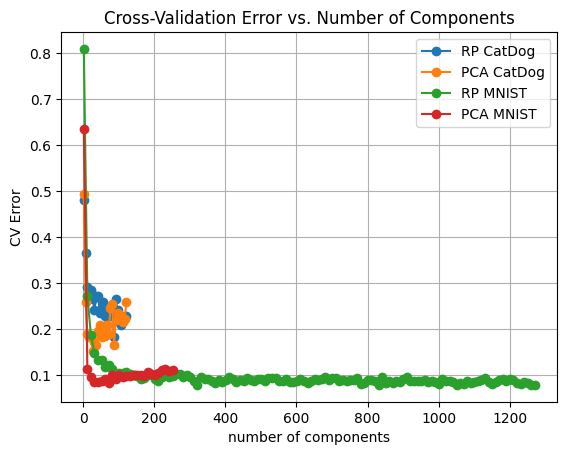

In [112]:
params1, errors1 = zip(*results_RF_RP_catdog['cv_error_per_param'])
params2, errors2 = zip(*results_RF_PCA_catdog['cv_error_per_param'])
params3, errors3 = zip(*results_RF_RP_mnist['cv_error_per_param'])
params4, errors4 = zip(*results_RF_PCA_mnist['cv_error_per_param'])
plt.plot(params1, errors1, marker='o', label='RP CatDog')
plt.plot(params2, errors2, marker='o', label='PCA CatDog') 
plt.plot(params3, errors3, marker='o', label='RP MNIST')
plt.plot(params4, errors4, marker='o', label='PCA MNIST') 
plt.title("Cross-Validation Error vs. Number of Components")
plt.xlabel("number of components")
plt.ylabel("CV Error")
plt.legend()
plt.grid(True)
plt.show()

# Embedded Lasso Logistic Regression & F-Test using Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

# F-Test and T-Test

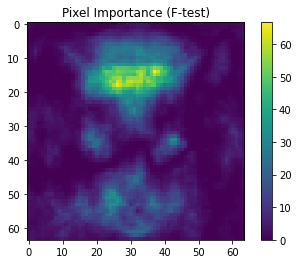

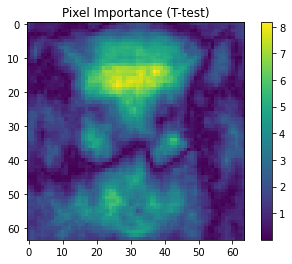

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


f_statistic, p_values = f_classif(X, y)
sorted_by_feature_index = np.argsort(f_statistic)[::-1] #descending order..

f_statistic_reshaped = np.reshape(f_statistic,(64,64))

plt.imshow(f_statistic_reshaped, cmap='viridis',interpolation="nearest")
plt.title("Pixel Importance (F-test)")
plt.colorbar()
plt.show()

X0 = X[y == 0]
X1 = X[y == 1]

t_statistics, p_values = ttest_ind(X0, X1)

sorted_by_feature_index_ttest = np.argsort(np.abs(t_statistics))[::-1]
t_statistics_reshaped = np.reshape(t_statistics, (64, 64))

plt.figure()
plt.imshow(np.abs(t_statistics_reshaped), cmap='viridis',interpolation="nearest")
plt.title("Pixel Importance (T-test)")
plt.colorbar()
plt.show()

# F-test w. Logistic Regression
Using CV, determine how many features (pixels) you need for classification
Repeat the above a few times - is the selection stable?

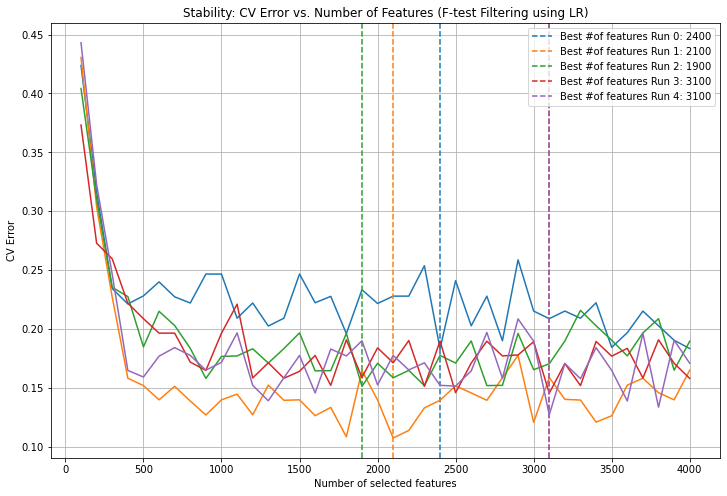

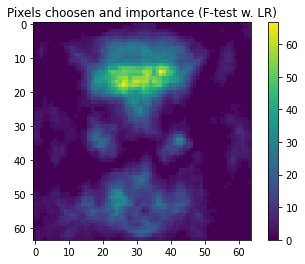

besk k mean: 2520.0 with standard deviation: 499.59983987187184


In [ ]:

classifier = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=10000)

feature_subsets = [k for k in range(100, 4100, 100)]
itterations = 5
all_errors = []  # List to store error curves from all runs

for itteration in range(itterations):
    #print(f"Run {itteration}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    CV_folds = KFold(n_splits=5, shuffle=True)

    feature_subset_errors = []
    for k in feature_subsets:
        selected_index = sorted_by_feature_index[:k]

        CV_errors = []

        for train_idx, test_idx in CV_folds.split(X_train, y_train):
            X_train_cv = X_train[train_idx][:, selected_index]
            y_train_cv = y_train[train_idx]

            X_test_cv = X_train[test_idx][:, selected_index]
            y_test_cv = y_train[test_idx]

            classifier.fit(X_train_cv,y_train_cv)
            yPred = classifier.predict(X_test_cv)
            CV_errors.append(zero_one_loss(y_test_cv, yPred))
        
        feature_subset_errors.append(np.mean(CV_errors))

    all_errors.append(feature_subset_errors)


all_errors = np.array(all_errors) 
best_ks = []

plt.figure(figsize=(12, 8))
for i in range(itterations):
    color = plt.cm.tab10(i % 10)
    best_k_index = np.argmin(all_errors[i])
    best_k = feature_subsets[best_k_index]
    best_ks.append(best_k)

    plt.plot(feature_subsets, all_errors[i],color = color)
    plt.axvline(best_k, linestyle='--', label=f'Best #of features Run {i}: {best_k:.0f}',color = color)

best_k_mean = np.mean(best_ks)
plt.xlabel("Number of selected features")
plt.ylabel("CV Error")
plt.title("Stability: CV Error vs. Number of Features (F-test Filtering using LR)")
plt.grid(True)
plt.legend()
plt.show()

heatmap = np.zeros(4096)
top_k_indices = sorted_by_feature_index[:int(best_k_mean)]
heatmap[top_k_indices] = f_statistic[top_k_indices]
heatmap_reshaped = np.reshape(heatmap,(64,64))

plt.imshow(heatmap_reshaped, cmap='viridis',interpolation="nearest")
plt.title("Pixels choosen and importance (F-test w. LR)")
plt.colorbar()
plt.show()

print(f"besk k mean: {np.mean(best_ks)} with standard deviation: {np.std(best_ks)}")

# Logistic Regression Lasso using CV to choose pentaly param with/without F-test
 λ: This regularization parameter controls the amount of regularization applied. Larger values of lambda increase the penalty, shrinking more of the coefficients towards zero; this subsequently reduces the importance of (or altogether eliminates) some of the features from the model, resulting in automatic feature selection. Conversely, smaller values of lambda reduce the effect of the penalty, retaining more features within the model.
 Use CV to determine the penalty param

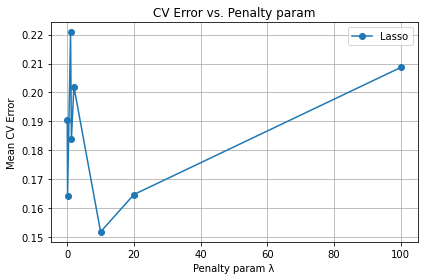

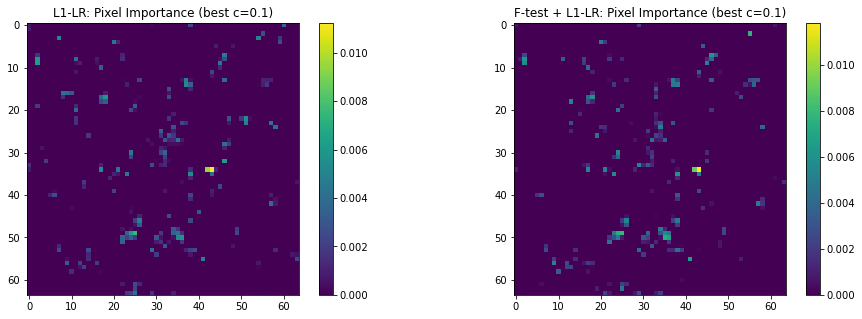

In [ ]:
#Try different penalties and perform CV to determine best
C = [100,10,1,0.8,0.5,0.1,0.05,0.01]
penalty_param_errors = []

selected_index = sorted_by_feature_index[:int(best_k_mean)]

for penalty_param in C:

    CV_errors = []
    CV_errors_F_test = []
    classifier = LogisticRegression(penalty='l1', solver='liblinear', C=penalty_param, max_iter=10000)
    CV_folds = KFold(n_splits=5, shuffle=True)

    for train_idx, test_idx in CV_folds.split(X_train, y_train):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]

        X_test_cv = X_train[test_idx]
        y_test_cv = y_train[test_idx]

        classifier.fit(X_train_cv,y_train_cv)

        yPred = classifier.predict(X_test_cv)

        CV_errors.append(zero_one_loss(y_test_cv, yPred))

    
    penalty_param_errors.append(np.mean(CV_errors))

best_c = C[penalty_param_errors.index(np.min(penalty_param_errors))]

"""Fit best c to data and retreive betas"""
best_classifier = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=10000)
best_classifier.fit(X_train,y_train)
#best_yPred = best_classifier.predict(X_test)
#best_loss = zero_one_loss(y_test,best_yPred)
betas = best_classifier.coef_
betas = np.reshape(betas, (64, 64))

"""Using Filtering F-test before"""
X_train_F_test = X_train[:, selected_index]
#X_test_F_test = X_test[:, selected_index]
best_classifier_F_test = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=10000)
best_classifier_F_test.fit(X_train_F_test,y_train)
#best_yPred_F_test = best_classifier_F_test.predict(X_test_F_test)
#best_loss_F_test = zero_one_loss(y_test,best_yPred_F_test)

betas_F_test = best_classifier_F_test.coef_

betas_F_test_full = np.zeros(4096)
betas_F_test_full[selected_index] = betas_F_test
betas_F_test_full = np.reshape(betas_F_test_full, (64, 64))

# Plot CV errors
lambdas = [1/c for c in C]
plt.figure()
plt.plot(lambdas, penalty_param_errors, marker='o', label='Lasso')
plt.xlabel("Penalty param λ")
plt.ylabel("Mean CV Error")
plt.title("CV Error vs. Penalty param")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(betas), cmap="viridis", interpolation="nearest")
plt.title(f"L1-LR: Pixel Importance (best c={best_c})")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.abs(betas_F_test_full), cmap="viridis", interpolation="nearest")
plt.title(f"F-test + L1-LR: Pixel Importance (best c={best_c})")
plt.colorbar()
plt.show()


#print(f"Best c value:{best_c}\nLoss without F-test filtering: {best_loss} and #of features = {len(betas)} \nLoss with F-test filtering: {best_loss} and #of features = {len(betas_F_test_full)} ")
